In [1]:
import pandas
import zipfile
import neurom
import os
import requests

from ipywidgets import widgets
from matplotlib import pyplot as plt
from neurom.check.runner import CheckRunner
from io import BytesIO

# Got this to work. But it reads the whole file at once into memory.
lnk = "https://drive.usercontent.google.com/download?id=1U6gTWtHvqOQo17UI00F5yqJQ_bU3mdGO&export=download&authuser=0"
fn_metadata = "metadata.json"
try:
    resp = requests.get(lnk)
    resp.raise_for_status()  # Check for HTTP errors
except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")
    raise
finally:
    resp.close()

try:
    f_zip = zipfile.ZipFile(BytesIO(resp.content))
except zipfile.BadZipFile as e:
    print(f"Zip archive appears to be malformed: {e}")
    raise

# Or just download the file and place it here.
## f_zip = zipfile.ZipFile("download.zip")

# The "metadata" is for now just dummy data I added.
assert fn_metadata in f_zip.namelist(), "{0} missing from zip file".format(fn_metadata)
all_contents = pandas.read_json(f_zip.open(fn_metadata))

# What types of files (extentions) are contained?
lst_extensions = all_contents['_filename'].apply(lambda _x: os.path.splitext(_x)[1].lower()).drop_duplicates()
lst_extensions = [_x for _x in lst_extensions if _x != ".h5"]  # I cannot get h5 to work
        
def morphology_from_zip(z_obj, fn):
    extension = os.path.split(fn)[1][1:]
    with z_obj.open(fn, "r") as fid:
        m_str = fid.read().decode("UTF-8")
    try:
        m = neurom.load_morphology(m_str, reader=extension)
    except Exception as e:
        print("Trouble with " + fn + ": " + str(e))
        return None
    return m


extension_wdgt = widgets.Dropdown(options=lst_extensions, description="Load extension")


In [2]:
# morphology_checks: concern the valid structure of a morphology
# options: set the tolerance parameters for the checks

config = {
    "checks": {
        "morphology_checks": [
            "has_axon",
            "has_basal_dendrite",
            "has_apical_dendrite",
            "has_no_jumps",
            "has_no_fat_ends",
            "has_nonzero_soma_radius",
            "has_all_nonzero_neurite_radii",
            "has_all_nonzero_section_lengths",
            "has_all_nonzero_segment_lengths",
            "has_no_flat_neurites",
            "has_nonzero_soma_radius",
            "has_no_narrow_start",
            "has_no_dangling_branch",
        ]
    },
    "options": {
        "has_nonzero_soma_radius": 0.0,
        "has_all_nonzero_neurite_radii": 0.007,
        "has_all_nonzero_segment_lengths": 0.01,
        "has_all_nonzero_section_lengths": 0.01,
    },
}
# create a CheckRunner object by providing the configuration dict
check_runner = CheckRunner(config)

display(extension_wdgt)

Dropdown(description='Load extension', options=('.asc', '.swc'), value='.asc')

In [6]:
contents = all_contents[all_contents["_filename"].apply(lambda _x: os.path.splitext(_x)[1] == extension_wdgt.value)]
contents["_morphology"] = contents["_filename"].apply(lambda _x: morphology_from_zip(f_zip, _x))
contents = contents[contents["_morphology"].apply(lambda _x: _x is not None)]

def run_wrapper(_morph):
    try:
        res = check_runner._check_loop(_morph, "morphology_checks")
        res = pandas.Series(res[1])
        res["Test ran to completion"] = True
    except:
        res = pandas.Series({"Test ran to completion": False})
    return res

res = contents["_morphology"].apply(run_wrapper)

/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_49153/1825685287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contents["_morphology"] = contents["_filename"].apply(lambda _x: morphology_from_zip(f_zip, _x))


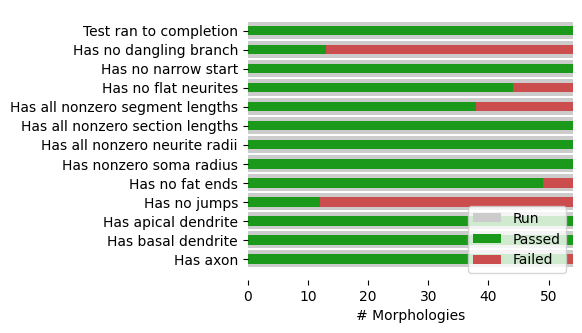

HTML(value='<b>Pick a test to list morphologies failing it</b>')

Dropdown(options=('Has axon', 'Has basal dendrite', 'Has apical dendrite', 'Has no jumps', 'Has no fat ends', …

HTML(value='')

In [7]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0.3, 0.1, 0.65, 0.9])
ttl = len(res) - res.isna().sum(axis=0)
passed = res.astype(int).sum(axis=0)
ax.barh(range(len(ttl)), ttl, height=0.9, color=[0.8, 0.8, 0.8], label="Run")
ax.barh(range(len(passed)), passed, height=0.5, color=[0.1, 0.6, 0.1], label="Passed")
ax.barh(range(len(passed)), ttl - passed, height=0.5, left=passed, color=[0.8, 0.3, 0.3], label="Failed")
ax.set_yticks(range(len(passed)))
ax.set_yticklabels(passed.index)
ax.set_xlabel("# Morphologies")
ax.set_frame_on(False)
plt.legend()
plt.show()

pick_test_wdgt = widgets.Dropdown(options=res.columns)
output = widgets.HTML()
display(widgets.HTML(
    value="<b>Pick a test to list morphologies failing it</b>"
))
display(pick_test_wdgt)
display(output)

def display_func(sel_test_name):
    col = res[sel_test_name]
    morphs = contents.name[col == False].values
    output.value=", ".join(list(morphs))
_ = widgets.interactive(display_func, sel_test_name=pick_test_wdgt)

